In [114]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt


eng = matlab.engine.start_matlab()

print("matlab egine started")

matlab egine started


In [115]:
eng.addpath(f"C:\\Users\\madan\\FH11_RFML\\gui\\waveform_functions", nargout=0)



In [ ]:
fs = 48e3
Tsymb = 1e-3
fc = 10e3
M = 64.0
Var = 1.0

sps = fs*Tsymb  
Nsymb = 2048

output_len = Nsymb*sps 

In [167]:
data = eng.mqam_gui(output_len, fs, Tsymb, fc, M)
data = np.array(data).flatten()

T = len(data)/fs

t = np.linspace(0,T,len(data))

MatlabExecutionError: 
  File C:\Users\madan\FH11_RFML\gui\waveform_functions\mqam_gui.m, line 21, in mqam_gui
Invalid data type. Argument must be double or single.


(0.0, 0.0425)

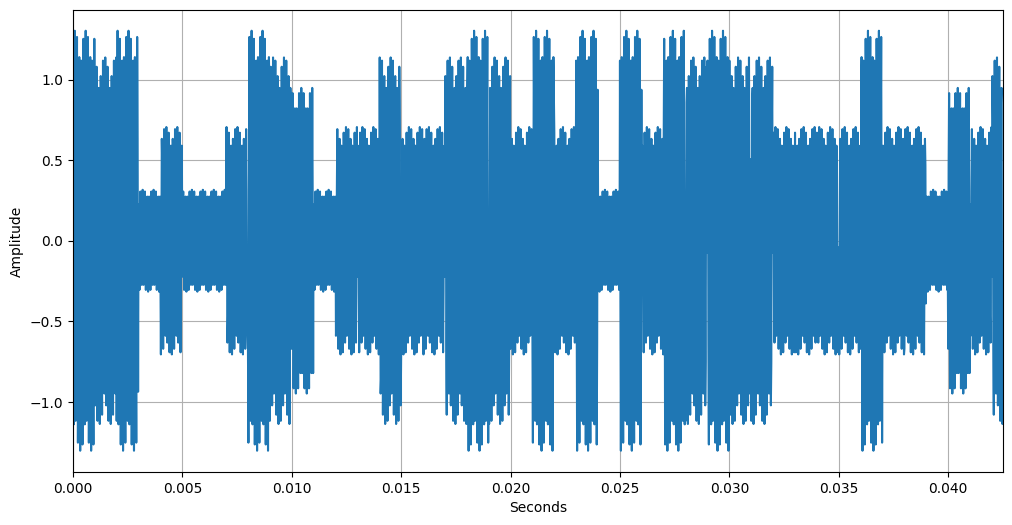

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(t,data)
plt.grid(True)
plt.xlabel("Seconds")
plt.ylabel("Amplitude")
plt.xlim([0,0.0425])

In [ ]:
freqs, ft = eng.plotspec_gui(data, 1/fs, nargout = 2)
freqs = np.array(freqs).flatten()
ft = np.array(ft).flatten()

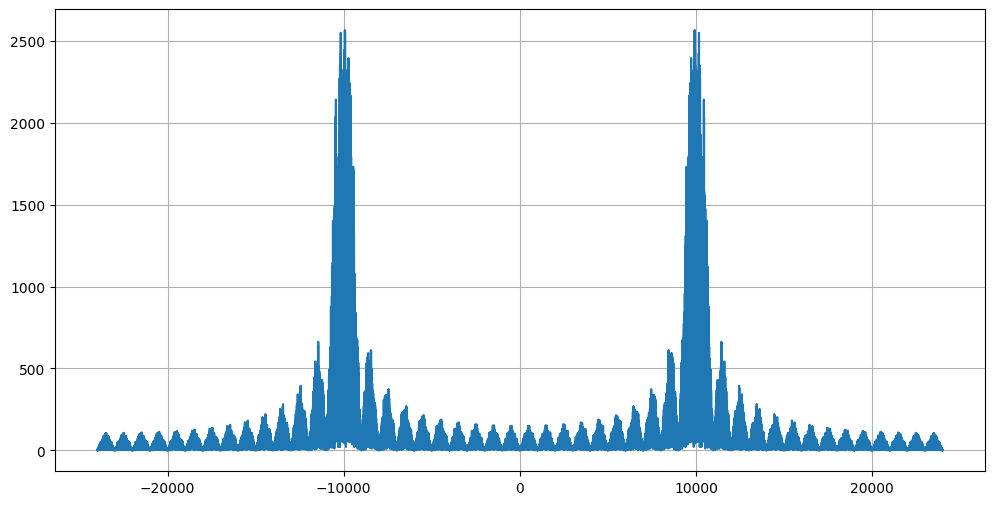

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(freqs, np.abs(ft))
plt.grid(True)

(-1.2300550166981155,
 1.230055015303514,
 -1.2298895339165044,
 1.229851995005787)

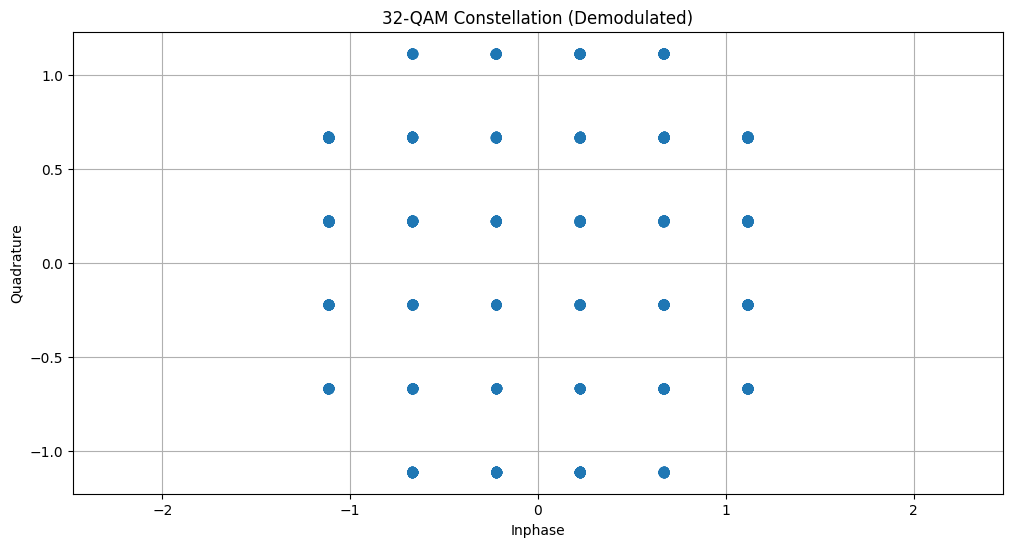

In [ ]:
from scipy import signal

plt.figure(figsize=(12,6))

# Proper I/Q demodulation
t_demod = np.arange(len(data)) / fs

# Demodulate I (in-phase) and Q (quadrature) components
I = data * 2 * np.cos(2*np.pi*fc*t_demod)
Q = data * (-2) * np.sin(2*np.pi*fc*t_demod)

# Low-pass filter to remove high-frequency components (2*fc)
# Design a low-pass filter with cutoff at fc/2
sos = signal.butter(4, fc/2, 'low', fs=fs, output='sos')
I_filtered = signal.sosfilt(sos, I)
Q_filtered = signal.sosfilt(sos, Q)

# Downsample to symbol rate (one sample per symbol)
# Take samples at the middle of each symbol period for best sampling point
offset = int(sps/2)  # Sample at center of symbol
I_symbols = I_filtered[offset::int(sps)]
Q_symbols = Q_filtered[offset::int(sps)]

plt.scatter(I_symbols, Q_symbols)
plt.grid(True)
plt.xlabel("Inphase")
plt.ylabel("Quadrature")
plt.title(f"{int(M)}-QAM Constellation (Demodulated)")
plt.axis('equal')
